<a href="https://colab.research.google.com/github/tymor22/tm-vec/blob/master/Embed_sequences_using_TM_Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library. 
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to embed protein sequences.


<h3>Embedding protein sequences using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, deepblast, and the huggingface transformers library**

In [ ]:
!pip install tm-vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 5.1 MB/s 
     |████████████████████████████████| 3.1 MB 66.4 MB/s 
     |████████████████████████████████| 5.8 MB 48.0 MB/s 
     |████████████████████████████████| 125 kB 77.6 MB/s 
     |████████████████████████████████| 512 kB 49.4 MB/s 
     |████████████████████████████████| 7.6 MB 47.7 MB/s 
     |████████████████████████████████| 182 kB 72.6 MB/s 
  Created wheel for tm-vec: filename=tm_vec-0.1.0-py3-none-any.whl size=9674 sha256=8f69b56db36f424347b701bd24b389def072fc833f19f87c9abe8b4f5d4b6b4e
  Stored in directory: /root/.cache/pip/wheels/90/cd/15/1f63ae4cfac3acbfecc598f120bcd4ad35d8caa47e6a473501
  Created wheel for deepblast: filename=deepblast-0.1.0-py3-none-any.whl size=38363 sha256=4a405b588dd57be78a136a621cb96e94ca0ebe827c81835da6bb766261078641
  Stored in directory: /root/.cache/pip/wheels/56/cf/4e/e77a41552db1e28f8d613076dad5

In [ ]:
!pip install deepblast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q SentencePiece transformers

     |████████████████████████████████| 1.3 MB 5.2 MB/s 


<b>2. Load the relevant libraries<b>

In [ ]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns 

<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

Downloading:   0%|          | 0.00/238k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

In [ ]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

Downloading:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.7.layer.2.layer_norm.weight', 'decoder.block.9.layer.1.EncDecAttention.k.weight', 'decoder.block.11.layer.0.SelfAttention.v.weight', 'decoder.block.12.layer.1.EncDecAttention.v.weight', 'decoder.block.9.layer.2.DenseReluDense.wo.weight', 'decoder.block.18.layer.1.layer_norm.weight', 'decoder.block.9.layer.0.SelfAttention.o.weight', 'decoder.block.22.layer.0.layer_norm.weight', 'decoder.block.9.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.15.layer.0.SelfAttention.o.weight', 'decoder.block.10.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.8.layer.1.EncDecAttention.v.weight', 'decoder.block.12.layer.0.SelfAttention.k.weight', 'decoder.block.6.layer.1.EncDecAttention.o.weight', 'decoder.block.22.layer.0

In [ ]:
gc.collect()

12

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cpu


In [ ]:
model = model.to(device)
model = model.eval()

<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt

--2022-12-21 15:41:47--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt [following]
--2022-12-21 15:41:47--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 207922348 (198M) [application/octet-stream]
Saving to: ‘tm_vec_cath_model.ckpt’

tm_vec_cath_model.c 100%[===================>] 198.29M  94.4MB/s    in 2.1s    

2022-12-21 15:41:50 (94.4 MB/s) - ‘tm_vec_cath_model.ckpt’ saved [207922348/207922348]



In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json

--2022-12-21 15:41:53--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json [following]
--2022-12-21 15:41:53--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 181 [application/json]
Saving to: ‘tm_vec_cath_model_params.json’

tm_vec_cath_model_p 100%[===================>]     181  --.-KB/s    in 0s      

2022-12-21 15:41:53 (29.8 MB/s) - ‘tm_vec_cath_model_params.json’ saved [181/181]



<b> 5. Load the trained TM-Vec model<b>

In [ ]:
#TM-Vec model paths
tm_vec_model_cpnt = "tm_vec_cath_model.ckpt"
tm_vec_model_config = "tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

<b> 6. Load or paste some sequences that you would like to embed <b>

In [ ]:
#Here we download CATH-S35 data
!wget https://users.flatironinstitute.org/thamamsy/public_www/cath-domain-seqs-S35-with-metadata.tsv

--2022-12-21 16:03:16--  https://users.flatironinstitute.org/thamamsy/public_www/cath-domain-seqs-S35-with-metadata.tsv
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/cath-domain-seqs-S35-with-metadata.tsv [following]
--2022-12-21 16:03:16--  https://users.flatironinstitute.org/~thamamsy/cath-domain-seqs-S35-with-metadata.tsv
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 7401800 (7.1M) [application/octet-stream]
Saving to: ‘cath-domain-seqs-S35-with-metadata.tsv’

cath-domain-seqs-S3 100%[===================>]   7.06M  28.4MB/s    in 0.2s    

2022-12-21 16:03:17 (28.4 MB/s) - ‘cath-domain-seqs-S35-with-metadata.tsv’ saved [7401800/7401800]



In [ ]:
cath_data = pd.read_csv('cath-domain-seqs-S35-with-metadata.tsv', sep="\t")

In [ ]:
#Sample some sequences to embed
cath_data_sample = cath_data.sample(50)
sequences = list(cath_data_sample['Sequence'].values)

<b> 7. Embed your sequences using TM-Vec <b> 



In [ ]:
#Loop through all of the sequences you have, and embed them
#This will be a lot faster (orders of magnitude) on a GPU
i = 0
sequence_embeddings = []
while i < len(sequences): 
    protrans_sequence = featurize_prottrans(sequences[i:i+1], model, tokenizer, device)
    embedded_sequence = embed_tm_vec(protrans_sequence, model_deep, device)
    sequence_embeddings.append(embedded_sequence)
    i = i + 1
    if i % 10 == 0:
      print(i, " Sequences embedded")

10  Sequences embedded
20  Sequences embedded
30  Sequences embedded
40  Sequences embedded
50  Sequences embedded


<b>8. Visualize your embedded sequences<b>

In [ ]:
#convert list of sequence embeddings into numpy array
sequence_embeddings_np = np.concatenate(sequence_embeddings, axis=0)

In [ ]:
sequence_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sequence_embeddings_np)

In [ ]:
#Make the relevant dataframe and add the metadata to it
sequence_tsne_df = pd.DataFrame(sequence_tsne)
sequence_tsne_df.columns = ["Dim1", "Dim2"]
sequence_tsne_df['Class'] = cath_data_sample['Class'].values
sequence_tsne_df['Architecture'] = cath_data_sample['Architecture'].values

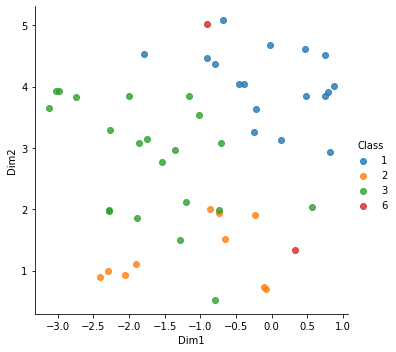

In [ ]:
#Visualize the TSNE, coloring by Class
sns.lmplot(x="Dim1", y="Dim2", data=sequence_tsne_df, hue="Class", fit_reg=False)